# ch04_随机梯度下降

## 4.1 激活函数与Loss的梯度

- torch.sigmoid()
$$f(x)=\sigma (x)=\frac{1}{1+e^{-x}}$$
$$\sigma ^{\prime } = \sigma *(1-\sigma )$$

- torch.tanh()
$$f(x)=\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}=2sigmoid(2x)-1$$

$$\frac{\mathrm{d} \tanh(x)}{\mathrm{d} x} = 1 - \frac{(e^x-e^{-x})^2}{e^x+e^{-x})^2} = 1 - \tanh^2(x)$$

- torch.relu()
$$
f(x) = \begin{cases} 0 
    & \text{ if }x<0 \\ x
    & \text{ if }x\ge0  
\end{cases}
$$

$$
{f}' (x) =\begin{cases} 0
  & \text{ if } x< 0 \\ 1
  & \text{ if } x\ge 0
\end{cases}
$$

### 4.1.2 Mean Squared Error 均方差 (MSE)
- MSE = torch.norm(y-pred,2).pow(2)
- L2范数的平方即MSE

$$ loss = \sum [ y-(xw+b) ]^2 $$
$$ L2_{norm} = \left \| y - (xw+b) \right\|_2 $$
$$ loss = norm( y - (xw + b)^2 $$



### 4.1.3 Softmax
$$
S(y_i) = \frac{e^{y_i}}{\sum_{j}{e^{y_j}}}
$$

#### softmax 求导
**原式:**
$$p_i = \frac{e^{a_i}}{\sum_{k=1}^{N}e^{a_k}}$$
**when i = j :**
$$
\frac{\partial \frac{e^{a_i}}{\sum_{k=1}^{N} e^{a_k}}}{\partial a_j}
= \frac{ e^{a_i}\sum_{k=1}^{N}e^{a_k} - e^{a_j}e^{a_i} }{ (\sum_{k=1}^{N} e^{a_k})^2 }
= \frac{ e^{a_i}(\sum_{k=1}^{N}e^{a_k} - e^{a_j}) }{(\sum_{k=1}^{N}e^{a_k})^2} \\
= \frac{e^{a_i}}{\sum_{k=1}^{N}e^{a_k}} \times \frac{(\sum_{k=1}^{N}e^{a_k} - e^{a_j})}{\sum_{k=1}^{N} e^{a_k}}
= p_j(1-p_j)
$$

**when i != j :**
$$
\frac{\partial \frac{e^{a_i}}{\sum_{k=1}^{N} e^{a_k}}}{\partial a_j}
= \frac{0 - e^{a_i}e^{a_j} }{(\sum_{k=1}^{N} e^{a_k})^2}
= \frac{-e^{a_j}}{\sum_{k=1}^{N} e^{a_k}} \times \frac{e^{a_i}}{\sum_{k=1}^{N} e^{a_k}}
= -p_jp_i
$$

#### 总结
假设:
$$P_i = [p_1,p_2,p_3]$$
$$a_j = [a_1,a_2,a_3]$$
$求p_1对a_j的偏导数,当p_1对a_1求偏导数时,i=j,偏导数为正数,等于p_j(1-p_j) \\
当对a_2,a_3求偏导数时,i!=j,偏导数为负数,等于-p_jp_i$

In [1]:
import torch
from torch.nn import functional as F
a = torch.rand(3)
a.requires_grad_()
print('a:\n',a)
p = F.softmax(a,dim=0)

print('p.backward(),backward()方法有个参数为retain_graph,只保留一次,再次调用backward(),要设置retain_graph=True ')
print('p = F.softmax(a,dim=0): ',p)
print('dp1_da = torch.autograd.grad(p[1],[a],retain_graph=True): ',
      torch.autograd.grad(p[1],[a],retain_graph=True))
print('dp2_da = torch.autograd.grad(p[2],[a])',torch.autograd.grad(p[2],[a]))

a:
 tensor([0.8146, 0.8519, 0.3415], requires_grad=True)
p.backward(),backward()方法有个参数为retain_graph,只保留一次,再次调用backward(),要设置retain_graph=True 
p = F.softmax(a,dim=0):  tensor([0.3758, 0.3901, 0.2341], grad_fn=<SoftmaxBackward>)
dp1_da = torch.autograd.grad(p[1],[a],retain_graph=True):  (tensor([-0.1466,  0.2379, -0.0913]),)
dp2_da = torch.autograd.grad(p[2],[a]) (tensor([-0.0880, -0.0913,  0.1793]),)


### 4.1.4 求梯度的方法
- **torch.autograd.grad ( loss, [w1,w2....] )**
 - [w1 grad , w2 grad...]
- **loss.backward ( )**
 - w1.grad
 - w2.grad
 - ...

In [2]:
import torch
from torch.nn import functional as F

x = torch.ones(1)
w = torch.full([1],2)
print('x: ',x)
print('w: ',w)
w.requires_grad_() # 没有这行代码,不会跟踪 w 的梯度
mse = F.mse_loss(torch.ones(1),x*w)
print('mse: ',mse,'\n\n')

print('使用autograd.grad求导数:')
print('torch.autograd.grad(mse,[w]):  ',torch.autograd.grad(mse,[w]),)


x:  tensor([1.])
w:  tensor([2.])
mse:  tensor(1., grad_fn=<MeanBackward0>) 


使用autograd.grad求导数:
torch.autograd.grad(mse,[w]):   (tensor([2.]),)


/Users/distiller/project/conda/conda-bld/pytorch_1591914879026/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


In [3]:
x = torch.ones(1)
w = torch.full([1],2)
print('x: ',x)
print('w: ',w)
w.requires_grad_() # 没有这行代码,不会跟踪 w 的梯度
mse = F.mse_loss(torch.ones(1),x*w)
print('mse: ',mse,'\n\n')

print('使用loss.backward求导数:')
print('mse.backward(): ')
mse.backward()
print('w.grad: ',w.grad)

x:  tensor([1.])
w:  tensor([2.])
mse:  tensor(1., grad_fn=<MeanBackward0>) 


使用loss.backward求导数:
mse.backward(): 
w.grad:  tensor([2.])


## 4.2 感知机

$$ y = XW + b $$
$$ y = \sum (x_i * w_i) + b$$
$梯度推导:\\ $
$$原式: L = \frac{1}{2}(O_0^1-t)^2$$
$$ \frac{\partial L}{\partial w_{j0}} = (O_0 - t)\frac{\partial O_0}{\partial w_{j0}}
= (O_0 - t)\frac{\partial \sigma(a_0^1)}{\partial w_{j0}}  
= (O_0 - t)\sigma(a_0^1)(1-\sigma(x_0^1))\frac{\partial x_0^1}{\partial w_{j0}} \\
   \frac{\partial L}{\partial w_{j0}} 
= (O_0 - t)O_0(1-O_0) \frac{\partial a_0^1}{\partial w_{j0}} 
= (O_0 - t)O_0(1-O_0)x_j^0$$

In [4]:
x = torch.rand(1,10)
w = torch.randn(1,10,requires_grad=True)
print('x: ',x,'\n')
print('w: ',w,'\n')
o = torch.sigmoid(x@w.t())
print('o = torch.sigmoid(x@w.t()): \n',o,'\n')

loss = F.mse_loss(torch.ones(1,1),o)
print('loss = F.mse_loss(torch.ones(1,1),o): ',loss,'\n','loss.shape: ',loss.shape)
print('mse_loss的第一个yapf_reformat数是pred,第二个参数是label\n')
loss.backward()
print('After loss.backward():')
print('w.grad: ',w.grad)

x:  tensor([[0.9900, 0.1211, 0.1241, 0.1363, 0.6657, 0.2323, 0.9576, 0.0927, 0.8517,
         0.6257]]) 

w:  tensor([[-1.6663, -0.3805, -1.1611, -0.4336,  0.2320, -0.2460, -0.1244,  0.6985,
         -1.0976,  0.6936]], requires_grad=True) 

o = torch.sigmoid(x@w.t()): 
 tensor([[0.0865]], grad_fn=<SigmoidBackward>) 

loss = F.mse_loss(torch.ones(1,1),o):  tensor(0.8344, grad_fn=<MeanBackward0>) 
 loss.shape:  torch.Size([])
mse_loss的第一个yapf_reformat数是pred,第二个参数是label

After loss.backward():
w.grad:  tensor([[-0.1430, -0.0175, -0.0179, -0.0197, -0.0961, -0.0335, -0.1383, -0.0134,
         -0.1230, -0.0904]])


## 4.3 链式法则:

In [5]:
x = torch.tensor(1.)
w1 = torch.tensor(2.,requires_grad=True)
b1 = torch.tensor(1.)
w2 = torch.tensor(2.,requires_grad=True)
b2 = torch.tensor(1.)

y1 = x*w1+b1
y2 = y1*w2+b2

dy2_dy1 = torch.autograd.grad(y2,[y1],retain_graph=True)[0]
dy1_dw1 = torch.autograd.grad(y1,[w1],retain_graph=True)[0]
dy2_dw1 = torch.autograd.grad(y2,[w1],retain_graph=True)[0]

print(dy2_dy1*dy1_dw1)
print(dy2_dw1)

tensor(2.)
tensor(2.)


## 4.4 反向传播算法

**Multi-Layer Perception:**

$$\frac{\partial L}{\partial w_{jk}} = (O_k-t_k) O_K (1-O_k) O_j^J \\
令 (O_k-t_k) O_K (1-O_k) O_j^J = \delta_k^K \\
\frac{\partial L}{\partial w_{jk}} = \delta_k^K O_j^J
$$



## 4.5 2D函数优化示例

$$ f(x,y) = ( x^2 + y - 11 )^2 + ( x + y^2 - 7 )^2 $$
$$
f(3.0,2.0) = 0.0 ,\\
f(-2.805118,3.131312) = 0.0 ,\\
f(3.779310,-3.283186) = 0.0 ,\\
f(3.584428,-1.848126) = 0.0 .
$$

x, y range:  (120,) (120,)
X, Y maps:  (120, 120) (120, 120)


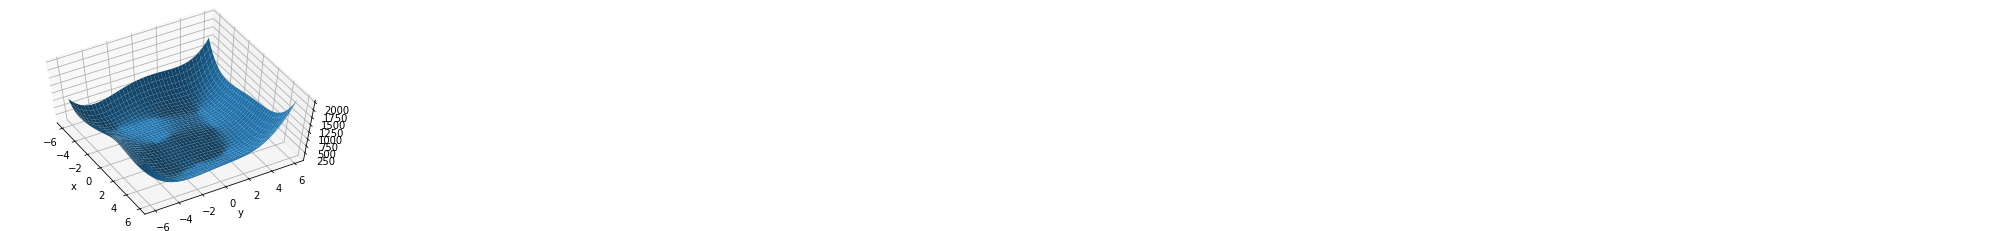

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def himmelblau(x):
    return (x[0]**2 + x[1] -11)**2 + (x[0] + x[1]**2 -7)**2
x = np.arange(-6,6,0.1)
y = np.arange(-6,6,0.1)
print('x, y range: ', x.shape,y.shape)
X,Y = np.meshgrid(x,y)
print('X, Y maps: ',X.shape,Y.shape)
Z = himmelblau([X,Y])

fig = plt.figure('himmelblau')
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(60,-30)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [9]:
x = torch.tensor([0.,0.],requires_grad=True)
optimizer = torch.optim.Adam([x],lr = 1e-3)
for step in range(20000):
    pred = himmelblau(x)
    optimizer.zero_grad()
    pred.backward()
    optimizer.step() # 更新一次 x,y
    
    if step%2000 == 0:
        print('step {}: x = {}, f(x) = {}'.format(step,x.tolist(),pred.item()))

step 0: x = [0.0009999999310821295, 0.0009999999310821295], f(x) = 170.0
step 2000: x = [2.3331806659698486, 1.9540694952011108], f(x) = 13.730916023254395
step 4000: x = [2.9820079803466797, 2.0270984172821045], f(x) = 0.014858869835734367
step 6000: x = [2.999983549118042, 2.0000221729278564], f(x) = 1.1074007488787174e-08
step 8000: x = [2.9999938011169434, 2.0000083446502686], f(x) = 1.5572823031106964e-09
step 10000: x = [2.999997854232788, 2.000002861022949], f(x) = 1.8189894035458565e-10
step 12000: x = [2.9999992847442627, 2.0000009536743164], f(x) = 1.6370904631912708e-11
step 14000: x = [2.999999761581421, 2.000000238418579], f(x) = 1.8189894035458565e-12
step 16000: x = [3.0, 2.0], f(x) = 0.0
step 18000: x = [3.0, 2.0], f(x) = 0.0
